# Experiment 3 Validation - Random Forest Baseline

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Step 0: Setup Environment
!pip install aif360 shap scikit-learn pandas matplotlib seaborn joblib openpyxl --quiet

In [21]:
# Step 1: Imports
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

In [22]:
# Step 2: Load and Preprocess Training Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Use 7 features to avoid mismatch
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'loan_amnt', 'zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income and loan amount
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])
df['loan_amnt'] = StandardScaler().fit_transform(df[['loan_amnt']])

In [23]:




# Step 3: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

X = aif_data.features
y = aif_data.labels.ravel()





In [24]:
# Step 4: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Save model as v2
MODEL_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/random_forest_model_v2.pkl'
joblib.dump(clf, MODEL_PATH)
print(f'Model retrained and saved to: {MODEL_PATH}')

Model retrained and saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/random_forest_model_v2.pkl


In [25]:
# Step 5: Preprocess Test Dataset (same 7 features)
def preprocess_testdata(df):
    df = df.copy()
    processed = pd.DataFrame()

    # Annual income
    scaler = StandardScaler()
    processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()

    # Term
    le = LabelEncoder()
    processed['term'] = le.fit_transform(df['term'].astype(str))

    # Grade
    le = LabelEncoder()
    processed['grade'] = le.fit_transform(df['grade'].astype(str))

    # Home ownership
    le = LabelEncoder()
    processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

    # Purpose
    le = LabelEncoder()
    processed['purpose'] = le.fit_transform(df['purpose'].astype(str))

    # Loan amount
    scaler = StandardScaler()
    processed['loan_amnt'] = scaler.fit_transform(df[['loan_amnt']].fillna(df['loan_amnt'].median())).ravel()

    # Protected attribute
    le = LabelEncoder()
    processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))

    # Target
    status_map = {
        'Fully Paid': 1,
        'Current': 1,
        'Charged Off': 0,
        'Default': 0,
        'Late (31-120 days)': 0,
        'Late (16-30 days)': 0,
        'In Grace Period': 0
    }
    df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
    processed['loan_status'] = df['loan_status_mapped']

    return processed.dropna()





In [28]:
# Step 6: Validation Function
def validate_on_testdata(df_processed, model):
    privileged_groups = [{'zip_code': 1}]
    unprivileged_groups = [{'zip_code': 0}]

    aif_data = StandardDataset(df_processed,
                               label_name='loan_status',
                               favorable_classes=[1],
                               protected_attribute_names=['zip_code'],
                               privileged_classes=[[1]])
    X = aif_data.features
    y = aif_data.labels.ravel()
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print('\nPERFORMANCE METRICS')
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print("AUC-ROC:", roc_auc_score(y, y_prob))

    print('\nClassification Report:')
    print(classification_report(y, y_pred, zero_division=0))

    print('\nFAIRNESS METRICS')
    pred_dataset = aif_data.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)
    metric = ClassificationMetric(aif_data, pred_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    print("Statistical Parity Difference:", metric.statistical_parity_difference())
    print("Disparate Impact:", metric.disparate_impact())
    print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
    print("Average Odds Difference:", metric.average_odds_difference())
    print("Bias Amplification:", metric.between_group_generalized_entropy_index())
    print("Theil Index:", metric.theil_index())

    print('\nEXPLAINABILITY METRICS')
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    X_df = pd.DataFrame(X, columns=aif_data.feature_names)
    # Handle binary vs multiclass safely
    if isinstance(shap_values, list):
      shap.summary_plot(shap_values[1], X_df, show=False)
    else:
      shap.summary_plot(shap_values, X_df, show=False)
    plt.title('SHAP Summary - Experiment 3 (Random Forest Baseline)')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/shap_exp3_testdata.png', dpi=150)
    plt.show()


    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'AUC': roc_auc_score(y, y_prob),
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'BiasAmp': metric.between_group_generalized_entropy_index(),
        'Theil': metric.theil_index()
    }




PERFORMANCE METRICS
Accuracy: 0.7076584683063387
Precision: 0.8348789283874292
Recall: 0.7978828163466273
F1 Score: 0.8159617321248741
AUC-ROC: 0.6161594591604361

Classification Report:
              precision    recall  f1-score   support

         0.0       0.27      0.32      0.29       939
         1.0       0.83      0.80      0.82      4062

    accuracy                           0.71      5001
   macro avg       0.55      0.56      0.55      5001
weighted avg       0.73      0.71      0.72      5001


FAIRNESS METRICS
Statistical Parity Difference: -0.25
Disparate Impact: 0.75
Equal Opportunity Difference: nan
Average Odds Difference: nan
Bias Amplification: 312.0625
Theil Index: 0.2209781692592573

EXPLAINABILITY METRICS


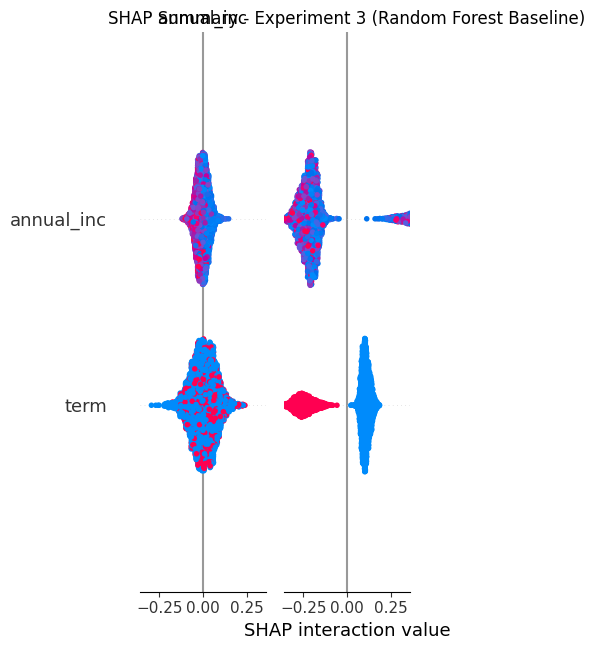

In [29]:
# Step 7: Run Validation
test_df = pd.read_excel('/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx')
test_processed = preprocess_testdata(test_df)
results = validate_on_testdata(test_processed, clf)

In [30]:
# Step 8: Save Results
results_df = pd.DataFrame([results])
output_path = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment3_validation_results_testdata.csv'
results_df.to_csv(output_path, index=False)
print(f'\nResults saved to: {output_path}')


Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment3_validation_results_testdata.csv
